# Simulationsgestützte Optimierung mit SciPy

In den nachfolgenden Aufgaben werden Sie mithilfe von scipy.optimize und Ihrem entwickelten Simulationsmodell das Energiesystem eines Gebäudes optimieren. Sie können die Aufgaben entweder direkt hier im Jupyter-Notebook ausarbeiten oder in einem eigenen Python-Skript (z.B. mit Spyder).

## Aufgabe 0

Instanzieren und testen Sie Ihr entwickeltes Simulationsmodell. Verwenden sie dafür folgende Parameterwerte:
* battery_kWh =  300
* pv_kWp = 192

Für die Trucks (und die übrigen Parameter) verwenden Sie die auch bisher verwendeten Einstellungen.
Testen Sie die Funktionsfähigkeit der Simulation, indem Sie die Funktion simulate() aufrufen. Lassen Sie sich die berechneten Gesamtkosten (system costs + operating costs über 10 Jahre) ausgeben. (0 %)

Energy Flows: 
Grid                 13237.0
PV to Truck          73631.0
PV to Battery        53493.0
PV to Grid           72239.0
Battery to Truck     53493.0
Grid to Truck        13237.0
Driven             -141129.0
dtype: float64
PV Yield: 199363kWh/a
self.system_cost=378_000.0€
self.operating_cost=151_852.2€/a
self.emissions=3574.0kg/a
self.self_consumption=0.6kWh
self.total_cost=1_896_522.1€/10a
self.load_cycles=178kwh

Total Battery Charge: 53493.33 kWh
Total Battery Discharge: 53493.33 kWh
>>>> ___Battery Charge = Battery Discharge___ <<<<

Total Energy Input: 140361.19 kWh
Total Energy Output from Trucks: 141129.45 kWh
>>>> ___Energy Input < Energy Output___ <<<<



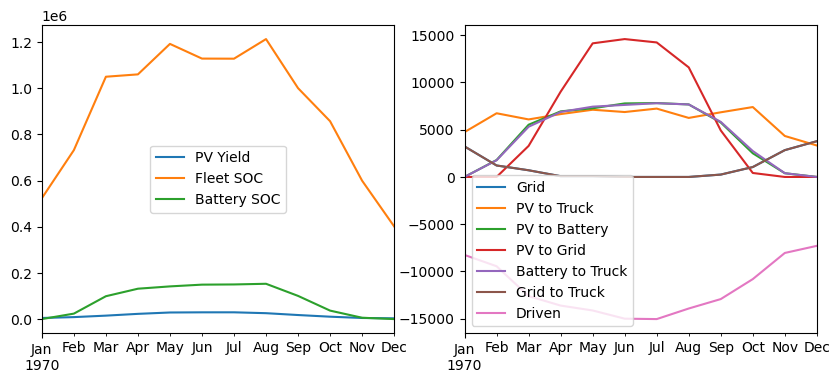

In [2]:

###~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
import pandas as pd
import Model as m
import matplotlib.pyplot as plt
###~~~~~~~~~~~~~~~~~~~~~~~~

# Result_pvb for simulate_pvb():
class Result_pvb:
    energy_balance: pd.DataFrame
    states: pd.DataFrame
    pv_kWp: float
    pv_cost_pkWp = 1500                    # was 1000
    battery_kWh: float                     # was float
    battery_cost_pkWh= 300                 # was 300
    grid_tarif_cpkWh = 50                  # was 0.19
    grid_feedin_cpkWh = 7.06               # was 0.05
    co2_intensity = 0.270                  # kg/kWh grid
    trucks: list

    @property
    def system_cost(self):
        return self.pv_cost_pkWp*self.pv_kWp + self.battery_cost_pkWh*self.battery_kWh
    
    #> Operating cost per annum? >
    @property
    def operating_cost(self):
        return self.energy_balance["Grid to Truck"].sum()*self.grid_tarif_cpkWh - self.energy_balance["PV to Grid"].sum()*self.grid_feedin_cpkWh
    
    @property
    def emissions(self):
        return self.energy_balance["Grid to Truck"].sum()*self.co2_intensity
    
    #> Self-consumption from "PV to Grid" to "PV to Truck" >
    @property
    def self_consumption(self):
        return 1-(self.energy_balance["PV to Truck"].sum()/self.states["PV Yield"].sum())
    
    @property
    def fleet_capacity(self):
        return sum(truck.capacity_kWh for truck in self.trucks)
    
    #> Total cost for 10 years >
    @property
    def total_cost(self):
        return self.system_cost + self.operating_cost * 10 

    #> Load-cycles battery charge >
    @property
    def load_cycles(self):
        total_charge = self.total_battery_charge
        return total_charge / self.battery_kWh  
    
    #> extension from Übung 3:
    @property
    def total_battery_charge(self):
        return self.energy_balance["PV to Battery"].sum()

    @property
    def total_battery_discharge(self):
        return self.energy_balance["Battery to Truck"].sum()

    @property
    def total_energy_input(self):
        return self.energy_balance[["PV to Truck", "Battery to Truck", "Grid to Truck"]].sum().sum()

    @property
    def total_energy_output(self):
        return self.energy_balance["Driven"].sum()

    def check_battery_balance(self):
        total_charge = self.total_battery_charge
        total_discharge = self.total_battery_discharge
        print(f"Total Battery Charge: {total_charge:.2f} kWh")
        print(f"Total Battery Discharge: {total_discharge:.2f} kWh")
        if total_charge == total_discharge:
            print(">>>> ___Battery Charge = Battery Discharge___ <<<<\n")
        elif total_charge > total_discharge:
            print(">>>> ___Battery charge > Battery Discharge___ <<<<\n")
        else:
            print(">>>> ___Battery charge < Battery Discharge___ <<<<\n")

    def check_energy_balance(self):
        total_input = self.total_energy_input
        total_output = self.total_energy_output
        if total_output < 0:
            total_output = abs(total_output)
        print(f"Total Energy Input: {total_input:.2f} kWh")
        print(f"Total Energy Output from Trucks: {total_output:.2f} kWh")
        if total_input == total_output:
            print(">>>> ___Energy Input = Energy Output___ <<<<\n")
        elif total_input > total_output:
            print(">>>> ___Energy Input > Energy Output___ <<<<\n")
        else:
            print(">>>> ___Energy Input < Energy Output___ <<<<\n")
    #>>>>> until here
    
    def visualize(self, resample=(None, None)):
        states, energy_balance = self.states, self.energy_balance
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        if resample[0] is not None:
            states = states.resample(resample[0]).sum()
        if resample[1] is not None:
            energy_balance = energy_balance.resample(resample[1]).sum()
        states.plot(ax=ax[0])
        energy_balance.plot(ax=ax[1])

    #> extension from Übung 3:    
        self.check_battery_balance()
        self.check_energy_balance()
    #>>>>> until here

    def __repr__(self):
        string = f"Energy Flows: \n{self.energy_balance.sum().round()}"
        string += f'\nPV Yield: {self.states["PV Yield"].sum().round():.0f}kWh/a'
        string += f"\n{self.system_cost=:_.1f}€"
        string += f'\n{self.operating_cost=:_.1f}€/a'                               
        string += f'\n{self.emissions=:.1f}kg/a'
        string += f'\n{self.self_consumption=:.1f}kWh'                              # added
        string += f'\n{self.total_cost=:_.1f}€/10a'                                 # added
        string += f'\n{self.load_cycles=:.0f}kwh\n'                                 # added
        return string
    
#> 1) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#> simulaion pv, battery and grid included >
def simulate_pvb(
        csv_dpath = "D:\SimMod_E-Post\data\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        battery_kWh = 2000,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                  # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvb()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results


# a fleet of 7 trucks
fleet_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 5), 
                               np.repeat([m.Etruck(schedule="worknight")], 2))).tolist()

# battery_kWh = b_kWh, pv_kWp = pv_kWo 
b_kWh = 300  
pv_kWo = 192  

# with pv and battery:
results01_pvb = simulate_pvb(trucks=fleet_trucks, battery_kWh=b_kWh, pv_kWp=pv_kWo)
print(results01_pvb)
results01_pvb.visualize(("M", "M"))

## Aufgabe 1

Definieren Sie eine Funktion *objective_function_PV(x)*, welche als Argument *x* die Leistung (kWp) der PV-Anlage erhält, den Wert entsprechend im Simulationsmodell setzt, die Simulation ausführt und die berechneten Gesamtkosten (system costs + operating costs über 10 Jahre) als Ergebnis zurückliefert. Der Parameter battery_kWh = 300 soll dabei unverändert bleiben. (10 %)

In [151]:
def objective_function_PV(x):
    res = simulate_pvb(trucks=fleet_trucks, battery_kWh=b_kWh, pv_kWp=x)
    return res.total_cost

## Aufgabe 2

Programmieren Sie eine einfache Grid Search (in 1D), indem Sie in einer for-Schleife die oben definierte Funktion *objective_function_PV()* für verschiedene kWp-Werte (im Bereich 50-800 kW in 50 kW-Schritten) aufrufen und die Rückgabewerte ausgeben (Funktion *print*). Bei welchem dieser kWp-Werte sind die berechneten Gesamtkosten am geringsten? (10 %)

In [152]:
# Grid Search in 1D
OUT = []
for kWp in range(50, 801, 50):
    out = objective_function_PV(kWp)
    print(f"kWp: {kWp}, has total cost -----> \n {round(out)} €/10a \n")
    OUT.append([kWp, round(out)])


kWp: 50, has total cost -----> 
 18932019 €/10a 

kWp: 100, has total cost -----> 
 10654856 €/10a 

kWp: 150, has total cost -----> 
 5614520 €/10a 

kWp: 200, has total cost -----> 
 1326111 €/10a 

kWp: 250, has total cost -----> 
 -2831781 €/10a 

kWp: 300, has total cost -----> 
 -7091240 €/10a 

kWp: 350, has total cost -----> 
 -11282265 €/10a 

kWp: 400, has total cost -----> 
 -15295881 €/10a 

kWp: 450, has total cost -----> 
 -19205942 €/10a 

kWp: 500, has total cost -----> 
 -23036603 €/10a 

kWp: 550, has total cost -----> 
 -26713886 €/10a 

kWp: 600, has total cost -----> 
 -30289613 €/10a 

kWp: 650, has total cost -----> 
 -33882682 €/10a 

kWp: 700, has total cost -----> 
 -37513102 €/10a 

kWp: 750, has total cost -----> 
 -41128282 €/10a 

kWp: 800, has total cost -----> 
 -44720739 €/10a 



In [155]:
# Nur positive Werte
OUTT = []
for i in range(0, len(OUT)):
    if (OUT[i][1] > 0):
        OUTT.append(OUT[i])

# Kovertierung list zum array
OUTT = np.array(OUTT)

# Minimum Kosten plus dazugehöriger kWp-Wert
min_cost = np.min(OUTT, axis=0)[1]
kwp_min_cost = OUTT[[np.where(OUTT == min_cost)][0][0]][0][0]

# Print
print(f"Geringste Gesamtkosten: {min_cost} €/10a mit {kwp_min_cost} kWp.")

Geringste Gesamtkosten: 1326111 €/10a mit 200 kWp.


## Aufgabe 3

Verwenden Sie die Funktion *scipy.optimize.minimize()* aus dem Python-Package *scipy* um den optimalen kWp-Wert für die PV-Anlage zu finden, der die Gesamtkosten minimiert. Verwenden Sie die oben definierte Funktion *objective_function_PV()* als Zielfunktion und legen Sie geeignete Grenzwerte (*bounds*) sowie einen sinnvollen Startwert *x0* fest.

(Hinweis: Unter Umständen kann der Rechenvorgang ein paar Minuten dauern.)

Falls Sie mit der Default-Methode Probleme haben, testen Sie auch andere Optimierungsverfahren (speziell 'trust-constr' oder auch 'CG'), indem Sie die Funktion *minimize* mit der ensprechenden Option *method='trust-constr'* bzw. method='CG' aufrufen. Ggf. kann es auch helfen die Toleranzen enger zu setzen (z.B. Option *tol=1e-6*). Nähere Details dazu können Sie in der Hilfe nachlesen.

Lassen Sie sich den Rückgabewert von *minimize()* in der Konsole ausgeben. Wie lautet der berechnete optimale kWp-Wert? (15 %)

In [162]:
from scipy.optimize import minimize

bounds = [(50, 800)]   # kWp-Werte zwischen 50 und 800
x0 = 150               # Startwert

result = minimize(objective_function_PV, x0, bounds = bounds, method = 'trust-constr', tol=1e-6)

print(result)

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -44727736.33793887
                 x: [ 8.000e+02]
               nit: 36
              nfev: 72
              njev: 36
              nhev: 0
          cg_niter: 34
      cg_stop_cond: 1
              grad: [-7.200e+04]
   lagrangian_grad: [ 7.276e-10]
            constr: [array([ 8.000e+02])]
               jac: [<1x1 sparse matrix of type '<class 'numpy.float64'>'
                    	with 1 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 7.200e+04])]
            method: tr_interior_point
        optimality: 7.275957614183426e-10
  constr_violation: 0.0
    execution_time: 31.125766038894653
         tr_radius: 2138.2224917627163
    constr_penalty: 1.0
 barrier_parameter: 0.020000000000000004
 barrier_tolerance: 0.020000000000000004
             niter: 

In [163]:
# Print optimalen Wert
print(f"Optimaler kWp-Wert: {round(result.x[0])}")

Optimaler kWp-Wert: 800


## Aufgabe 4

Definieren Sie eine zweite Funktion *objective_function_2D(x)*, welche als Inputwert x einen Vektor (Liste) aus den beiden Parametern
* Dimenstionierung (kWp) der PV-Anlage
* Batteriekapazität

erhält, die Parameter entsprechend im Simulationsmodell setzt, die Simulation ausführt und die berechneten Gesamtkosten (system costs + operating costs über 10 Jahre) als Ergebnis zurückliefert. (10 %)

In [166]:
def objective_function_2D(params):
    kWp, battery_capacity = params
    res = simulate_pvb(trucks=fleet_trucks, battery_kWh=battery_capacity, pv_kWp=kWp)
    return res.total_cost

## Aufgabe 5

Verwenden Sie wieder die Funktion *scipy.optimize.minimize()* aus dem Package scipy um sowohl den kWp-Wert für die PV-Anlage als auch die Batteriekapzazität gleichzeitig zu optimieren. Verwenden Sie dazu die oben definierte Funktion *objective_function_2D()* als Zielfunktion und legen Sie geeignete Grenzwerte (*bounds*) sowie sinnvolle Startwerte *x0* fest.
Testen Sie auch andere Optimierungsverfahren (speziell 'trust-constr') und vergleichen Sie die Ergebnisse. (15 %)

In [172]:
from scipy.optimize import minimize

bounds = [(50, 800), (50, 500)]  # kWp zwischen 50 und 800, Batteriekapazität zwischen 50 und 500
x0 = [150, 100]                  # Startwerte für kWp und Batteriekapazität

result_trust_constr = minimize(objective_function_2D, x0, bounds = bounds, method ='trust-constr', tol = 1e-6)
result_default = minimize(objective_function_2D, x0, bounds = bounds, tol = 1e-6)                        

print("Ergebnisse mit trust-constr ----- >\n", result_trust_constr)
print("\nErgebnisse mit default ----- >\n", result_default)

Ergebnisse mit trust-constr ----- >
            message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -44012427.658524096
                 x: [ 8.000e+02  5.000e+02]
               nit: 36
              nfev: 108
              njev: 36
              nhev: 0
          cg_niter: 43
      cg_stop_cond: 4
              grad: [-7.313e+04 -2.065e+03]
   lagrangian_grad: [-2.455e-08  4.782e-08]
            constr: [array([ 8.000e+02,  5.000e+02])]
               jac: [<2x2 sparse matrix of type '<class 'numpy.float64'>'
                    	with 2 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 7.313e+04,  2.065e+03])]
            method: tr_interior_point
        optimality: 4.782486939802766e-08
  constr_violation: 0.0
    execution_time: 43.550543785095215
         tr_radius: 2667.598513314243
    constr_penalty: 1.0
 barrie

*Ergebnisse mit default* zeigt ABNORMAL_TERMINATION_IN_LINSRCH Fehler, sehr wahrscheinlich braucht das default Modell ein nicht-lineares Suchverfahren.

## Aufgabe 6

Verwenden Sie anstelle von *minimize()* die Funktion *scipy.optimize.differential_evolution()* um das Optimum mittels Differential-Evolution-Verfahren zu berechnen. Legen Sie dazu wieder geeignete Grenzen (*bounds*) fest. Vergleichen Sie die Ergebnisse mit jenen aus Aufgabe 5.
> Hinweis: Wie genau die Funktion differential_evolution aufgerufen werden kann (und welche Input-Argumente sie erlaubt bzw. benötigt), können Sie in der Dokumentation nachlesen: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

Probieren Sie auch verschiedene Verfahrensparameter aus, speziell die Populationsgröße (*popsize*) sowie Mutations- und Rekombinationsraten (*mutation*, *recombination*). (15 %)

In [173]:
from scipy.optimize import differential_evolution

bounds = [(50, 800), (50, 500)]  # kWp zwischen 50 und 800, Batteriekapazität zwischen 50 und 500

result_diffe = differential_evolution(objective_function_2D, bounds, popsize = 10, mutation = (0.5, 1), recombination = 0.7, tol = 1e-6)

print("Ergebnisse mit Differential Evolution ----- >\n", result_diffe)

Ergebnisse mit Differential Evolution ----- >
  message: Optimization terminated successfully.
 success: True
     fun: -47521574.81813301
       x: [ 8.000e+02  8.000e+01]
     nit: 55
    nfev: 1327


## Aufgabe 7

Vergleichen Sie die Rechenzeit sowie die Anzahl der Funktionsauswertungen 
* zwischen *minimize()* im 1D-Fall (Aufgabe 3) und im 2D-Fall (Aufgabe 5),
* zwischen *minimize()* (Aufgabe 5) und *differential_evolution()* (Aufgabe 6), 

indem die Werte jeweils in einer Tabelle gegenüberstellen. Welches der Verfahren ist im jeweiligen Fall effizienter? (10 %)
> Hinweis: Die Anzahl der Funktionsauswertungen (*nfev*) wird Ihnen von den beiden Funktionen jeweils mit zurück geliefert. Um die Rechenzeit zu bestimmen, vergleichen Sie die Zeiten vor und nach dem Funktionsaufruf. Verwenden Sie dazu das Python-Package *time*:  
>> *import time  
>> t = time.time()  
>> (...Funktionsaufruf...)  
>> elapsed_time = time.time() - t*  



In [182]:
# Nur als Muster:
import time
stime = time.time()
#... Funktionsaufruf ...
RUN1 = time.time()-stime
print(RUN1)

# Diese Arbeit wurde in Visual Studio Code durchgeführt wo die Rechenzeite automatisch gezeigt sind.
# Sekunden:
Aufgabe3_s = 31.9
Aufgabe5_s = 70.4
Aufgabe6_s = 740.2

# Anzahl der Funktionsauswertungen;
Aufgabe3_nfev = 72
Aufgabe5_nfev = 108   # nicht fehlerhaftes 'trust-constr' Verfahren 
Aufgabe6_nfev = 1327  

import pandas as pd

data = [['3', Aufgabe3_s, Aufgabe3_nfev], 
        ['5', Aufgabe5_s, Aufgabe5_nfev], 
        ['6', Aufgabe6_s, Aufgabe6_nfev]]
 
df = pd.DataFrame(data, columns=['Aufgabe', 'Laufzeit', 'N_FunkAusW'])
df

0.0


,Aufgabe,Laufzeit,N_FunkAusW
0,3,31.9,72
1,5,70.4,108
2,6,740.2,1327


In [183]:
# FAll 1 >-----
print(df[(df['Aufgabe'] != '6')])

# FAll 2 >-----
print(df[(df['Aufgabe'] != '3')])

  Aufgabe  Laufzeit  N_FunkAusW
0       3      31.9          72
1       5      70.4         108
  Aufgabe  Laufzeit  N_FunkAusW
1       5      70.4         108
2       6     740.2        1327


Rechenzeit (Laufzeit) stieg mit steigender Anzahl der Funktionsauswertungen. Im FALL 1 Aufgabe 3 ist besser da die x-Werte gleich sind, aber sie war schneller als Aufgabe 5. Im FALL 2 sind die simulierte x_Werte unterschiedlich *([800, 500] vs. [800, 800])*, Aufgabe 5 war aber wesentlich schneller, daher ist sie eine bessere Wahl als Aufgabe 6. Unter Aufgabe 3, 5, und 6 sind die eingebetteten Simulationsverfahren zu verstehen.

## Aufgabe 8

Variieren Sie andere Parameterwerte aus der Simulation, speziell
* Energiepreise,
* Trucks Anzahl und schedules,

in sinnvollen Bereichen per Hand und führen Sie die Optimierungsläufe von Aufgabe 5 nochmals durch. Wie stark ändern sich die optimalen PV- und Batteriewerte?  
(15 %)

In [ ]:
#### NICHT GEMACHT #####
# Man sollte die simulate() Funktion aus explorer.ipynb verwenden und anpassen, ich habe das (optimierte) entwickelte Simulationsmodell das das unter Funktion simulate_pvb() läuft, verwendet.
